In [3]:
import re
import datetime
from glob import glob 
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from method import * 

file_paths = glob('/Volume/VAD/LifeLongerAD_cu121/results/ReverseDistillation/MVTecAD/drift_rep_norm-*/seed_42/results/main.csv')

results = {fp.split('/')[-6]+'-' + fp.split('/')[-4] : pd.read_csv(fp) for fp in file_paths}

# 메인 성능 

In [5]:
df = pd.DataFrame()

for k,v in results.items():
    try: 
        v.loc[v['class_name']=='AA']
        temp = v.loc[v['class_name']=='AA'].drop(columns=['Unnamed: 0','last'])
        temp['method'] =k.split('-')[0]
        temp['Continual'] = k.split('-')[-2].split('_')[-1]
        temp['Online'] = k.split('-')[-1].split('_')[-1]
        
        df = pd.concat([df,temp])
    except:
        temp = pd.DataFrame(v.drop(columns=['Unnamed: 0','GT_class_name']).mean()).T
        temp['method'] =k.split('-')[0]
        temp['Continual'] = k.split('-')[-2].split('_')[-1]
        temp['Online'] = k.split('-')[-1].split('_')[-1]
        df = pd.concat([df,temp])

In [6]:
df[df['method']=='ReverseDistillation'].pivot_table(index=['Continual','Online'],values=['img_level_auroc','img_level_average_precision','pix_level_auroc','pix_level_average_precision'])

img_level_auroc  img_level_average_precision  \
Continual Online                                                 
False     False          0.973516                     0.989385   
          True           0.838357                     0.923654   
True      False          0.736047                     0.875363   
          True           0.678346                     0.838780   

                  pix_level_auroc  pix_level_average_precision  
Continual Online                                                
False     False          0.972120                     0.582974  
          True           0.936226                     0.393034  
True      False          0.823885                     0.255135  
          True           0.807559                     0.166436

# 메인 성능 변화 

In [14]:
file_paths = glob('/Volume/VAD/LifeLongerAD_cu121/results/ReverseDistillation/MVTecAD/drift_rep_norm-*/seed_42/results/result_log.csv')

results = {fp.split('/')[-6]+'-' + fp.split('/')[-4] : pd.read_csv(fp) for fp in file_paths}

In [20]:
metric_list = ['img_level_auroc','img_level_average_precision','pix_level_auroc','pix_level_average_precision']

def cal_results_continual_true(df):
    cln_results = {} 
    for cln in class_name:
        temp = df[(df['last']==1) & (df['class_name']==cln)]    
        cln_results[cln] = temp[metric_list].mean(1).values
    return cln_results     

exp_results = {}
for exp_name, df in results.items():
    class_name = df['class_name'].unique()
    
    if df['last'].sum()>0: # continual on 
        cln_results = cal_results_continual_true(df)
        exp_results[exp_name] = cln_results
    elif df['last'].sum()==0: # continual off 
        
        pass     

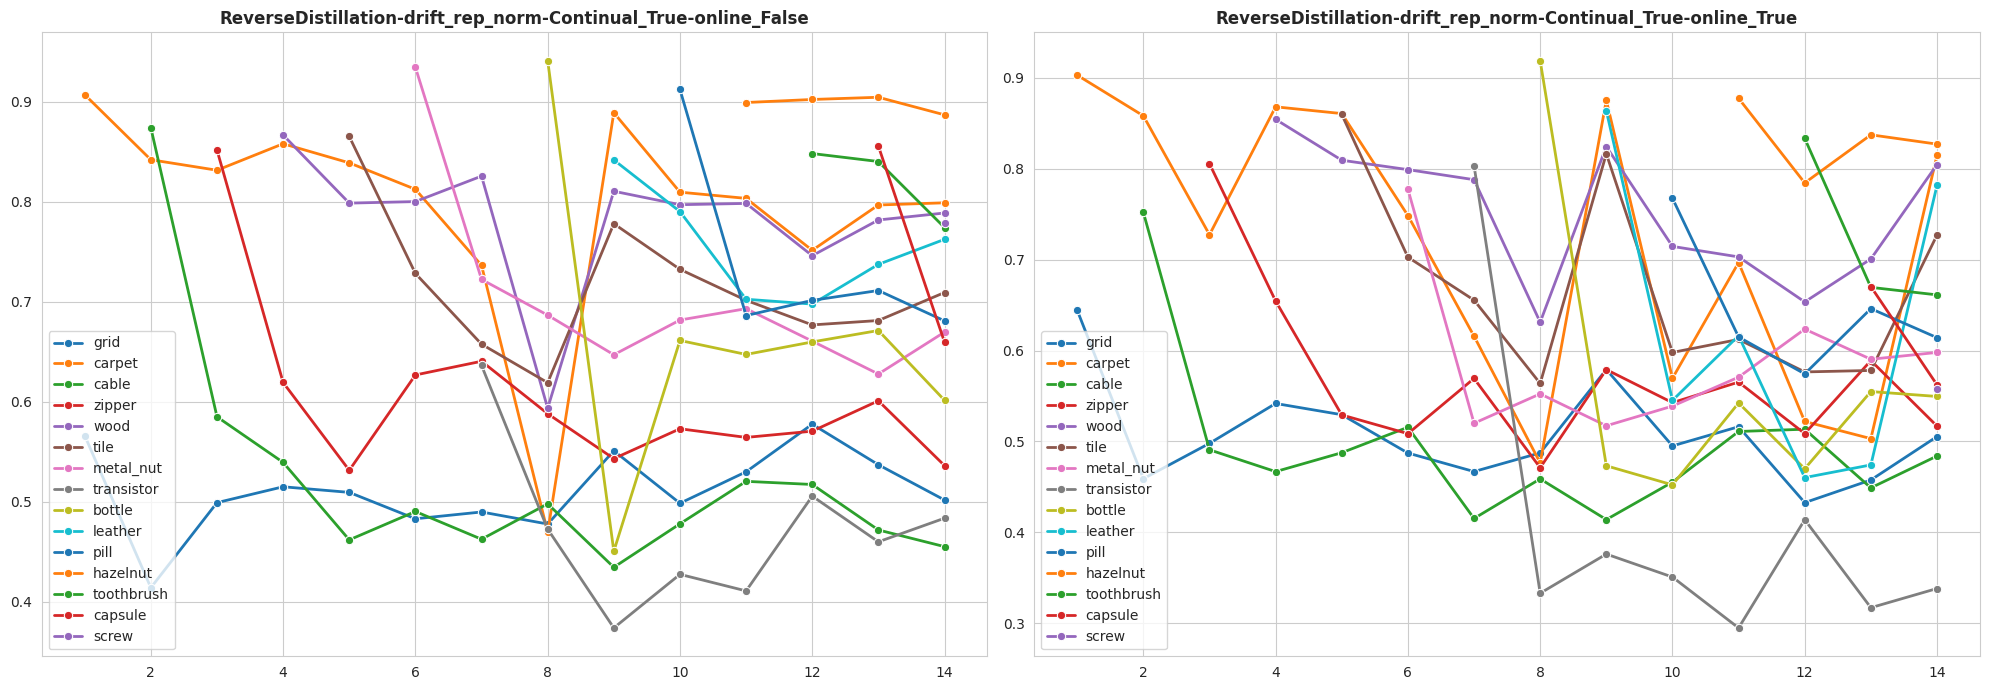

In [26]:

fig,axes = plt.subplots(1,2, figsize=(20,7))
axes = axes.flatten()
sns.set_style("whitegrid")

for i,(exp_name, df) in enumerate(exp_results.items()):
    
    for cln, results in df.items():
        sns.lineplot(
            y = results[1:],
            x = [r for r in range(15-len(results[1:]),15)],
            ax = axes[i],
            label=cln, marker="o", linewidth=2
        )
    
    axes[i].set_title(exp_name,weight='bold')
    
plt.tight_layout()
plt.show()

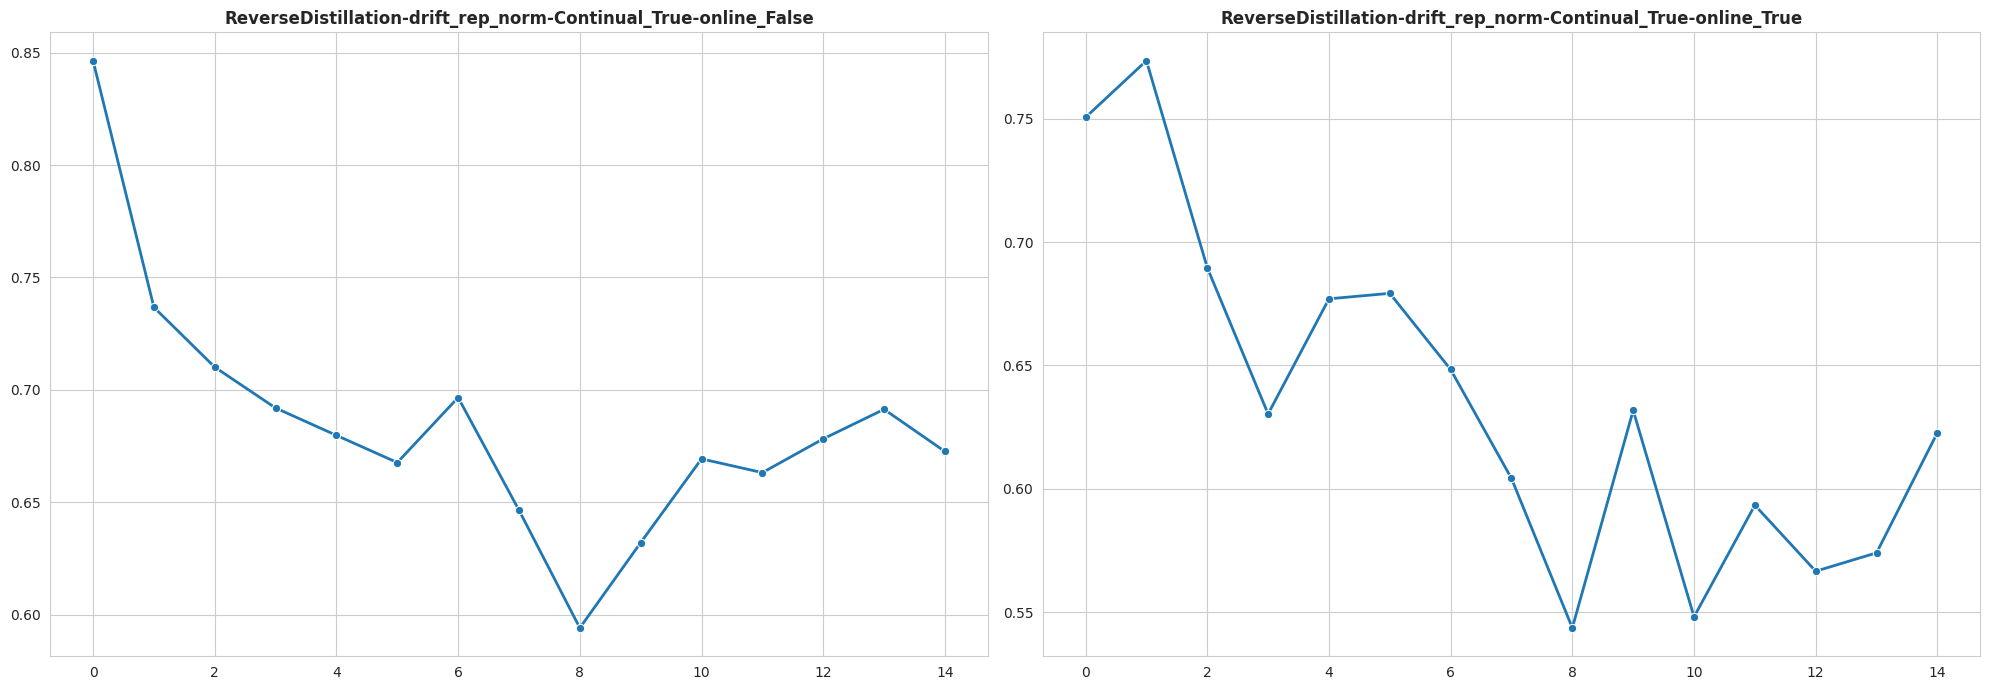

In [27]:
fig,axes = plt.subplots(1,2, figsize=(20,7))
axes = axes.flatten()
sns.set_style("whitegrid")

for i,(exp_name, df) in enumerate(exp_results.items()):
    
    mother = pd.DataFrame()
    for cln, results in df.items():
        if cln == 'grid':
            temp = pd.DataFrame(results)            
        else:
            temp = pd.DataFrame(results[1:])
            temp.index=[r for r in range(15-len(results[1:]),15)]
        temp.columns = [cln] 
        mother = pd.concat([mother,temp.T])
        
    sns.lineplot(
            mother.mean(),
            ax = axes[i],
            marker="o", linewidth=2
        )
    
    axes[i].set_title(exp_name,weight='bold')
    
plt.tight_layout()
plt.show()

In [31]:
exp_name

'ReverseDistillation-drift_rep_norm-Continual_True-online_True'

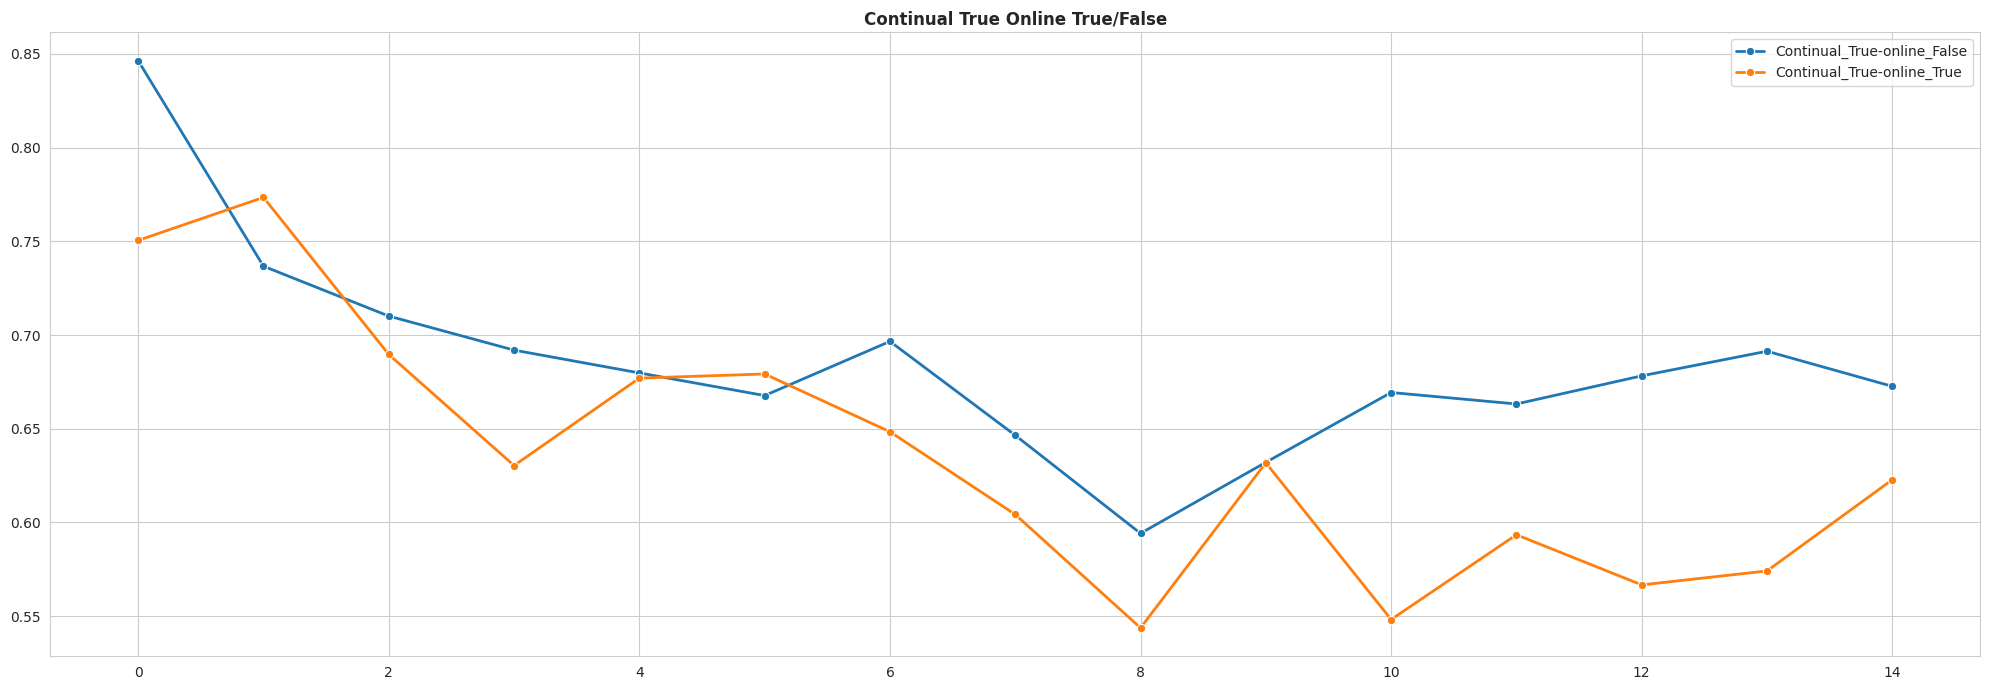

In [37]:
fig,axes = plt.subplots(1,1, figsize=(20,7))

sns.set_style("whitegrid")

for i,(exp_name, df) in enumerate(exp_results.items()):
    
    mother = pd.DataFrame()
    for cln, results in df.items():
        if cln == 'grid':
            temp = pd.DataFrame(results)            
        else:
            temp = pd.DataFrame(results[1:])
            temp.index=[r for r in range(15-len(results[1:]),15)]
        temp.columns = [cln] 
        mother = pd.concat([mother,temp.T])
        
    sns.lineplot(
            mother.mean(),
            ax = axes,
            marker="o", linewidth=2,
            label=exp_name.replace('ReverseDistillation-drift_rep_norm-','')
        )
    
    axes.set_title('Continual True Online True/False',weight='bold')
    
plt.tight_layout()
plt.show()